In [1]:
from pymongo import MongoClient
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from sympy import degree
from tqdm import tqdm
import math
import seaborn as sns
import powerlaw as plw
import datetime
from IPython.display import display, clear_output
import plotly.graph_objects as go
from reddit import plotting, network
from reddit import datahandling as dh
%load_ext autoreload
%autoreload 2

In [2]:
client = MongoClient('localhost', 27017)
db = client.reddit

def getUTC(date):
    return date.replace(tzinfo=datetime.timezone.utc).timestamp()

In [3]:
def plotDegreedistr(G, axis, in_degree=False, out_degree=False):
    if in_degree:
        degr = np.array(G.in_degree())[:,1]
    elif out_degree:
        degr = np.array(G.out_degree())[:,1]
    else:
        degr = np.array(G.degree())[:,1]
    #alpha = plotting.plotpowerlaw(degr, axis, show_fit=True, discrete=False, xmin=1)
    plotting.plotlognormal(degr, axis, show_fit=True, discrete=False, xmin=1)
    num_usrs = np.unique(edges[0]).shape[0]
    return 0, num_usrs


Get dataframe from mongodb!


KeyboardInterrupt: 

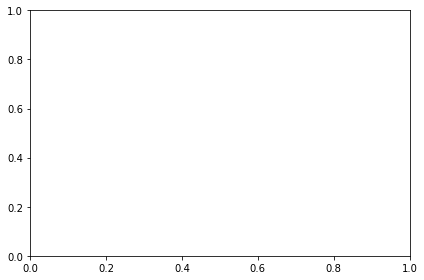

In [34]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
data = dh.getData(db,'politics',start=0,end=1,which='comments', save=False, verbose=True)
edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)
a, n = plotDegreedistr(G,axis)
a, n = plotDegreedistr(G,axis, in_degree=True)
a, n = plotDegreedistr(G,axis, out_degree=True)
print(n)
print(nx.number_weakly_connected_components(G)/n)
axis.loglog()
axis.legend()

Try different Distributions 

-39.77285130497462 0.0


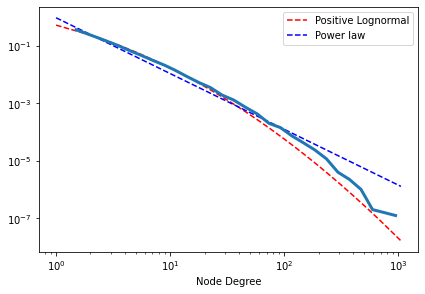

In [45]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
#data = dh.getData(db,'politics',start=0,end=1,which='comments', save=False, verbose=True)
#edges = (np.vstack((data[:,3], data[:,4])))
#G = network.genNewNet(edges=edges)
degr = np.array(G.in_degree())[:,1]
data_nonzero = degr[degr > 0]
fit = plw.Fit(data_nonzero, discrete=False, xmin=1, linear_bins=True)
R, p = fit.distribution_compare('lognormal_positive','power_law',normalized_ratio = True) #positive lognorm cause negative mean makes no sense
print(R,p)
#fit.power_law.plot_pdf(ax=axis, color = 'r', linestyle = '-')
fit.lognormal_positive.plot_pdf(ax=axis, color='r', linestyle='--', **{'label': 'Positive Lognormal'})
fit.power_law.plot_pdf(ax=axis, color='b', linestyle='--', **{'label': 'Power law'})
fit.plot_pdf(ax=axis, lw=3, original_data=True)
axis.set_xlabel('Node Degree')


axis.legend()

Get dataframe from mongodb!


KeyboardInterrupt: 

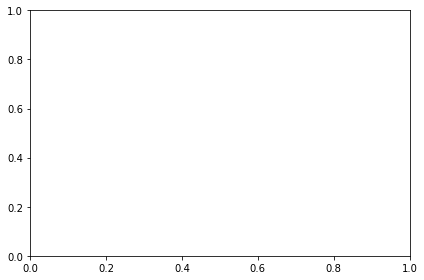

In [26]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
data = dh.getData(db,'counting',start=0,end=1,which='comments', save=False, verbose=True)
edges = (np.vstack((data[:,3], data[:,4])))
G = network.genNewNet(edges=edges)
a, n = plotDegreedistr(G,axis)
a, n = plotDegreedistr(G,axis, in_degree=True)
a, n = plotDegreedistr(G,axis, out_degree=True)
print(nx.number_weakly_connected_components(G))
axis.loglog()
axis.legend()

0it [00:00, ?it/s]c:\Users\valen\anaconda3\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
1it [00:19, 19.56s/it]c:\Users\valen\anaconda3\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
2it [00:39, 19.63s/it]c:\Users\valen\anaconda3\lib\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distributio

KeyboardInterrupt: 

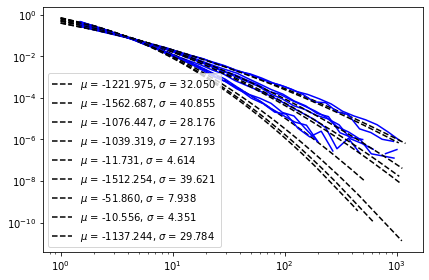

In [49]:
subreddits = dh.getTop(client.reddit_statistics, 10, 'comments')
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,14))
alpha = []
num_usrs = []
for idx, sr in tqdm(enumerate(subreddits)):
    if sr != ['distantsocializing'] and sr != ['RedditSessions']:
        data = dh.getData(db,sr.item(),start=start,end=end,which='comments', save=False)
        edges = (np.vstack((data[:,3], data[:,4])))
        G = network.genNewNet(edges=edges)
        a, n = plotDegreedistr(G,axis,in_degree=True, )
        alpha.append(a)
        num_usrs.append(n)


axis.loglog()
axis.legend()

Text(0.5, 1.0, 'Sorted Exponents Top 100 subreddits')

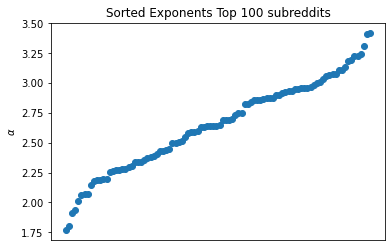

In [51]:
alpha_sorted = np.sort(alpha)
x = np.arange(np.shape(num_usrs)[0])
#plt.scatter(num_usrs,alpha)
#plt.scatter(dn, da, color='red')
plt.xticks([], [])
plt.scatter(x, alpha_sorted)
plt.ylabel(r'$\alpha$')
plt.title('Sorted Exponents Top 100 subreddits')
#plt.xscale('log')

2it [00:47, 23.65s/it]


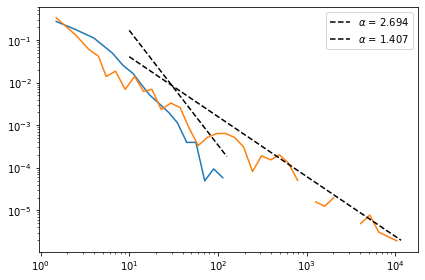

In [43]:
subreddits = dh.getTop(client.reddit_statistics, 1, 'comments')
subreddits = ['churning', 'counting']
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
da = []
dn = []
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,14))
for idx, sr in tqdm(enumerate(subreddits)):
    if sr != ['distantsocializing'] and sr != ['RedditSessions']:
        data = dh.getData(db,sr,start=start,end=end,which='comments', save=False)
        a, n = plotDegreedistr(data,axis)
        da.append(a)
        dn.append(n)

axis.loglog()
axis.legend()

## Different Timescales

[0.013946251805146059, 0.004387035765535681, 0.004615758768915231, 0.002099403150971675, 0.0026517621842498656, 0.0018918199412686642, 0.001905146489637321, 0.0010182892935025963, 0.0010317902535428743, 0.0010097782025479485, 0.0010668504321223093, 0.0011218763596885042, 0.001083251325721095, 0.0011001661373842922, 0.0008777191720704957, 0.0009085721825530018, 0.0009287192610410705, 0.0009584617582407792, 0.0008786734147284007, 0.0009117258699079569, 0.0007288820686382053, 0.0007059069847969805, 0.0006738954105923774, 0.000681569574396432, 0.0006659826890356762, 0.0006614033768977403, 0.0006550536272750173, 0.0006554115374658773, 0.0006594032413932895, 0.0006747388526964174, 0.0006752950393732874, 0.0006679075239860907, 0.0006755481206961878, 0.0006698046600194659, 0.0006846421324584015, 0.0006777531491643628, 0.0006810314096812035, 0.0006721306824458554, 0.000679698438043145, 0.0006753542505597359, 0.0006771760677450532, 0.0006743989008279078, 0.0006783580664390394, 0.0006782968302270

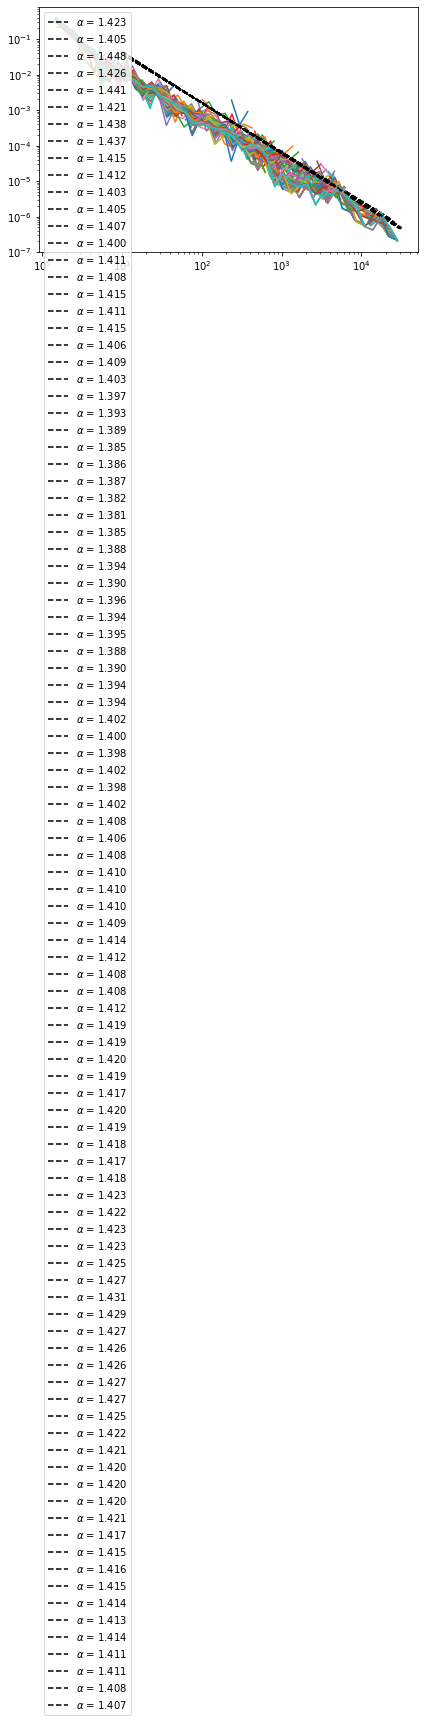

In [70]:
fig, axis = plt.subplots(1)
fig.set_figheight(4)
fig.set_figwidth(6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)
color = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
start = getUTC(datetime.datetime(2020,1,1))
end = getUTC(datetime.datetime(2020,1,2))
alpha = []
num_usrs = []
cc = []
for i in range(100):
    data = dh.getData(db,'counting',start=start,end=end+i*86400 ,which='comments', save=False)
    edges = (np.vstack((data[:,3], data[:,4])))
    G = network.genNewNet(edges=edges)
    in_degr = np.array(G.in_degree())[:,1]
    a = plotting.plotpowerlaw(in_degr, axis, show_fit=True, discrete=False, xmin=10)
    n = np.unique(edges[0]).shape[0]
    M = nx.DiGraph()
    for u,v in G.edges():
        if M.has_edge(u,v):
            M[u][v]['weight'] += 1
        else:
            M.add_edge(u, v, weight=1)
    cc.append(nx.average_clustering(M,weight='weight'))
    alpha.append(a)
    display(fig)    
    clear_output(wait = True)
    num_usrs.append(n)
    print(cc)
    plt.pause(0.1)
display(fig)    
axis.loglog()
axis.legend()

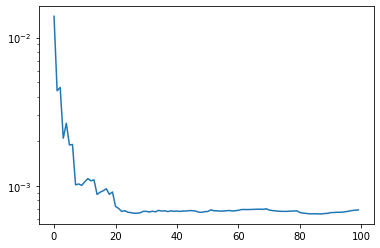

In [72]:
plt.plot(np.arange(np.shape(cc)[0]),cc)
plt.yscale('log')

In [1]:
plt.plot(np.arange(np.shape(alpha)[0]),alpha)

NameError: name 'plt' is not defined

In [68]:
pol_cc = cc

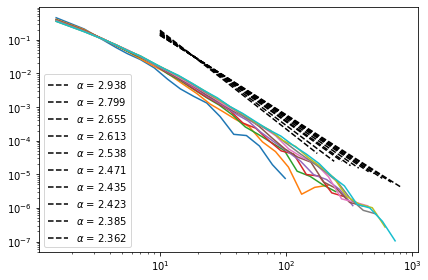

In [61]:
display(fig)    

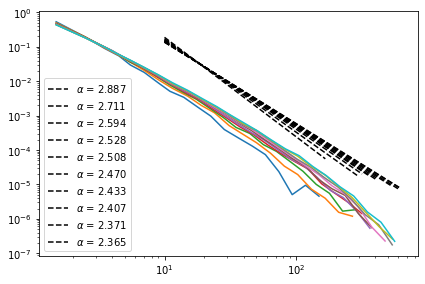

In [59]:
display(fig)    